<a href="https://colab.research.google.com/github/ric-colasanti/Giabbanelli/blob/main/Single_Networked_Giabbanelli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random as rnd
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython.display import clear_output,display, HTML
from time import sleep
import ipywidgets as widgets 
import networkx as nx
import numpy as np
from matplotlib.colors import ListedColormap
dbug = True

In [ ]:
def debug(do,str,val):
    global dbug
    if do and dbug :print(str,val)

In [ ]:
html = HTML('<img src="https://ric-colasanti.github.io/Methods/NNM/img/img4.png" width="650px">')
display(html)
print("Giabbanelli core metabolic model")

Giabbanelli core metabolic model




From Westerterp

REE Resting energy expenditure (Mj/d)

BW Body weight (kg)

LM Lean mass (Kg)

FM Fat mass (Kg)

LM = 0.75 * BW

FM = 0.25 * BW

Lean mass energy expeniture
LMee = LM * 0.102

Fat mass energy expenditure
FMee = FM * 0.024

Resting energy expenditure constant
REEc = 0.85 

EI Energy intake  (Mj/d)

EIee Energy expenditure from energy intake
EI * 0.1

PA Physical activity
This is a multiplier of REE

REE = LMee + FMee + REEc 

EE Energy expenditure (Mj/d)

EE = PA * REE + EIee

DE = EI - EE

See *Giabbanelli, Philippe J., et al. "Modeling the influence of social networks and environment on energy balance and obesity." Journal of Computational Science 3.1-2 (2012): 17-27*.[Download](https://ric-colasanti.github.io/Methods/NNM/papers/Modeling%20the%20influence%20of%20social%20networks%20and%20environment%20on%20energy%20balance%20and%20obesity.pdf)

In [ ]:
class Counter:
  def __init__(self):
      self.tnow =0
      self.tnext = 1
  def update(self):
    # This switches the 0 1 state of now and next
      self.tnow = (self.tnow+1) % 2
      self.tnext = (self.tnext+1) % 2



In [ ]:
class Agent:
    def __init__(self,counter,id = "agent"):
        self.links = []
        self.id = id
        self.number_of_links =0
        self.counter = counter

    def addBiLink(self,agent):
        self.links.append(agent)
        agent.links.append(self)
        self.number_of_links+=1 
        agent.number_of_links+=1 

    def addLink(self,agent):
        self.links.append(agent)
        self.number_of_links+=1 
        
    @property
    def tnext(self):
        return self.counter.tnext

    def printState(self):
        txt = "id {} "
        print(txt.format(self.id),end =" ")

In [ ]:
class GiabbanelliAgent (Agent):
    env = 1.0 # uniform environmental influence
    t_ei = 0.1 # threshold energy intake
    t_pa = 0.1 # threshold physical activity
    i_ei = 0.0 # impact on energy intake
    i_pa = 0.0 # impact on physical activity
    lm_c = 0.75 # lean mass constant
    fm_c = 0.25 # fat mass constant
    lm_e_c = 0.102 # lean mass energy constant
    fm_e_c = 0.024 # fat mass energy constant
    de_kg = 1/32.2 # energy to body mass
    r_ee_c = 0.85 #Resting energy expenditure constant 
    tef = 0.1 # Thermic effect of food
    
    def __init__(self, weight,physical_activity,counter,id ="Giabbanelli"):
        super().__init__(counter,id)
        self.body_weight = weight
        self.physical_activity_a = [physical_activity,physical_activity]
        ei = physical_activity*self.r_ee/0.9
        self.energy_intake_a = [ei,ei] # initial energy intake assuming constant weight
        self.inf_pa = 0.0
        self.inf_ei = 0.0

    @property
    def physical_activity(self):
        debug(False,"PA get",self.physical_activity_a[self.counter.tnow])
        return self.physical_activity_a[self.counter.tnow]

    @physical_activity.setter
    def physical_activity(self,value):
        self.physical_activity_a[self.counter.tnext]=value
        debug(False,"PA set",self.physical_activity_a[self.counter.tnext])

    @property
    def energy_intake(self):
        debug(False,"EI get",self.energy_intake_a[self.counter.tnow])
        return self.energy_intake_a[self.counter.tnow]

    @energy_intake.setter
    def energy_intake(self,value):
        self.energy_intake_a[self.counter.tnext] = value
        debug(True,"EI Set",self.energy_intake_a[self.counter.tnext])

    @property
    def lm(self): # Lean mass
        return GiabbanelliAgent.lm_c * self.body_weight
    @property
    def fm(self): #Fat mass
        return GiabbanelliAgent.fm_c * self.body_weight
    
    @property 
    def lm_ee(self):  #Lean mass energy expenditure
        return self.lm* GiabbanelliAgent.lm_e_c

    @property
    def fm_ee(self): #Fat mass energy expenditure
        return self.fm* GiabbanelliAgent.fm_e_c

    @property
    def r_ee(self): #Resting energy expenditure 
        return self.lm_ee + self.fm_ee + GiabbanelliAgent.r_ee_c

    def calcInfluence(self):
        self.inf_pa = 0.0
        self.inf_ei = 0.0
        if len(self.links)>0:
            #print(len(self.links))
            for agent in self.links:
                self.inf_pa += agent.physical_activity - self.physical_activity
                self.inf_ei += agent.energy_intake - self.energy_intake
            self.inf_pa = self.inf_pa/self.number_of_links
            self.inf_ei = self.inf_ei/self.number_of_links
        
        
    def nextPA(self):# Physical activity
        debug(True,"inf_pa",self.inf_pa)
        inf_pa_env=0
        # Environmental effect
        if self.inf_pa>=0:
            inf_pa_env = GiabbanelliAgent.env*self.inf_pa
        else:
            inf_pa_env = self.inf_pa/GiabbanelliAgent.env


        # if pos link_influence is above the  threshold the add influence * intake
        if inf_pa_env>= GiabbanelliAgent.t_pa * self.physical_activity:
            self.physical_activity = self.physical_activity + (GiabbanelliAgent.i_pa * self.physical_activity)
        # if neg link_influence is below the  neg threshold the subtract influence * intake
        elif inf_pa_env<= -GiabbanelliAgent.t_pa * self.physical_activity:
            self.physical_activity = self.physical_activity - (GiabbanelliAgent.i_pa * self.physical_activity)
        else:
            self.physical_activity = self.physical_activity  # do not change
        
    def nextEI(self): # energy intake
        inf_ei_env=0
        # Environmental effect
        if self.inf_ei<0:
            inf_ei_env = GiabbanelliAgent.env*self.inf_ei
        else:
            inf_ei_env = self.inf_ei/GiabbanelliAgent.env
        
        # if pos link_influence is above the  threshold the add influence * intake
        if inf_ei_env>= GiabbanelliAgent.t_pa * self.energy_intake:  
            self.energy_intake = self.energy_intake + (GiabbanelliAgent.i_ei * self.energy_intake)
        # if neg link_influence is below the  neg threshold the subtract influence * intake
        elif inf_ei_env<= - GiabbanelliAgent.t_pa * self.energy_intake:
            self.energy_intake = self.energy_intake - (GiabbanelliAgent.i_ei * self.energy_intake)
        else:
            self.energy_intake = self.energy_intake # do not change

    def updateBodyWeight(self):
        ei_ee =  self.energy_intake * GiabbanelliAgent.tef  #Energy expenditure from energy intake 
        ee = self.physical_activity * self.r_ee + ei_ee # Energy expenditure
        de = self.energy_intake - ee # Differance in energy expenditure and energy intake
        self.body_weight += de* GiabbanelliAgent.de_kg # Change in body mass
        txt = "LM: {:.3f} FM: {:.3f} EEei: {:.3f} REE: {:.3f} EI-EE: {:.3f} "
        #print(txt.format(self.lm,self.fm,ei_ee,ee,de))

    def iterate(self):
        self.updateBodyWeight()
        self.calcInfluence()
        self.nextEI()
        self.nextPA()
        
    
    def printState(self):
        super().printState()
        txt = "Weight: {:.5f} Energy intake: {:.3f} Physical activity: {:.3f} "
        print(txt.format(self.body_weight,self.energy_intake,self.physical_activity))



        

Google sheet of the Giabbanelli metabolic model



In [ ]:
html = HTML('<iframe width=1100 src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTKrDU9a9es3i48IvHuWyPRqbHgJ3I5Qjmh4GLHx9xlLAq9y60jSkfndS9pAwfNVbFHNMCoDchLyuW-/pubhtml?gid=0&amp;single=true&amp;widget=true&amp;headers=false"></iframe>')
display(html)

id subject  Weight: 77.10000 Energy intake: 12.178 Physical activity: 1.520 
Increse energy intake by 10%
id subject  Weight: 77.10000 Energy intake: 13.396 Physical activity: 1.520 
id subject  Weight: 77.13404 Energy intake: 13.396 Physical activity: 1.520 
id subject  Weight: 77.16794 Energy intake: 13.396 Physical activity: 1.520 
id subject  Weight: 77.20172 Energy intake: 13.396 Physical activity: 1.520 
id subject  Weight: 77.23536 Energy intake: 13.396 Physical activity: 1.520 
id subject  Weight: 77.26887 Energy intake: 13.396 Physical activity: 1.520 


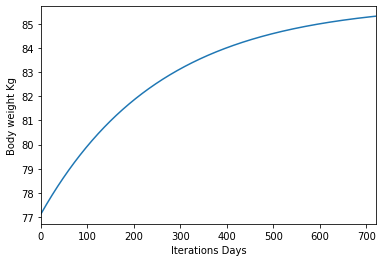

In [ ]:
counter = Counter()
dbug = False
testAgent = GiabbanelliAgent(77.1,1.52,counter,"subject")
testAgent.printState()
print("Increse energy intake by 10%")
testAgent.energy_intake_a[0]+=testAgent.energy_intake*0.1
testAgent.energy_intake_a[1]+=testAgent.energy_intake*0.1
testAgent.printState()
time = []
wdata=[]
iterations = 720
for t in range(iterations):
    testAgent.updateBodyWeight()
    time.append(t)
    if t<5:
        testAgent.printState()
    wdata.append(testAgent.body_weight)
plt.plot(time,wdata)
plt.xlim([0,iterations])
plt.xlabel("Iterations Days")
plt.ylabel("Body weight Kg")
plt.show()


In [ ]:
html = HTML('<iframe width=1100 src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTKrDU9a9es3i48IvHuWyPRqbHgJ3I5Qjmh4GLHx9xlLAq9y60jSkfndS9pAwfNVbFHNMCoDchLyuW-/pubhtml?gid=1094961935&amp;single=true&amp;widget=true&amp;headers=false"></iframe>')
display(html)

id subject  Weight: 77.10000 Energy intake: 12.178 Physical activity: 1.520 
Increse PA intake by 10%
id subject  Weight: 77.10000 Energy intake: 12.178 Physical activity: 1.672 
id subject  Weight: 77.06596 Energy intake: 12.178 Physical activity: 1.672 
id subject  Weight: 77.03207 Energy intake: 12.178 Physical activity: 1.672 
id subject  Weight: 76.99832 Energy intake: 12.178 Physical activity: 1.672 
id subject  Weight: 76.96472 Energy intake: 12.178 Physical activity: 1.672 
id subject  Weight: 76.93126 Energy intake: 12.178 Physical activity: 1.672 


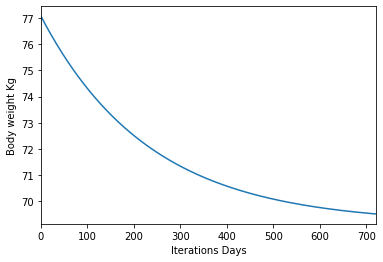

In [ ]:
counter = Counter()
dbug = False
testAgent = GiabbanelliAgent(77.1,1.52,counter,"subject")
testAgent.printState()
print("Increse PA intake by 10%")
testAgent.physical_activity_a[0]+=testAgent.physical_activity*0.1
testAgent.physical_activity_a[1]+=testAgent.physical_activity*0.1
testAgent.printState()
time = []
wdata=[]
iterations = 720
for t in range(iterations):
    testAgent.updateBodyWeight()
    time.append(t)
    if t<5:
        testAgent.printState()
    wdata.append(testAgent.body_weight)
plt.plot(time,wdata)
plt.xlim([0,iterations])
plt.xlabel("Iterations Days")
plt.ylabel("Body weight Kg")
plt.show()

id subject  Weight: 77.10000 Energy intake: 12.178 Physical activity: 1.520 
id contact  Weight: 70.10000 Energy intake: 13.266 Physical activity: 1.800 




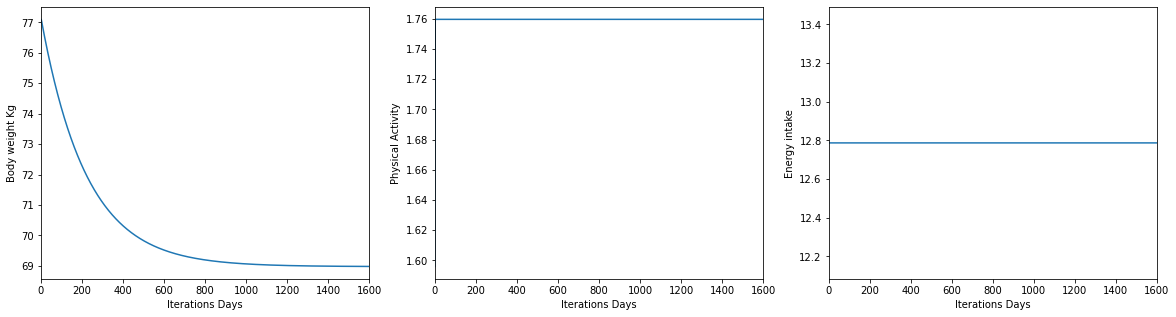

In [ ]:
counter = Counter()
testAgent =  GiabbanelliAgent(77.1,1.52,counter,"subject")
testAgent.printState()
testConnect= GiabbanelliAgent(70.1,1.8,counter,"contact")
#testConnect.energy_intake_a = testAgent.energy_intake_a
testConnect.printState()
testAgent.addLink(testConnect)
testAgent.addLink(testConnect)
testAgent.addLink(testConnect)
testAgent.addLink(testConnect)

print()
dbug=0
GiabbanelliAgent.env = 0.93 # uniform environmental influence
GiabbanelliAgent.t_ei = 0.06# threshold energy intake
GiabbanelliAgent.t_pa = 0.06 # threshold physical activity
GiabbanelliAgent.i_ei = 0.05 # impact on energy intake
GiabbanelliAgent.i_pa = 0.05 # impact on physical activity

time = []
wdata=[]
pdata=[]
edata=[]
iterations=1600

for t in range(iterations):
    #testAgent.printState()
    #testConnect.printState()
    testAgent.iterate()
    #print("-")
    counter.update()
    bw = testAgent.body_weight
    pa = testAgent.physical_activity
    ei = testAgent.energy_intake
    time.append(t)
    wdata.append(bw)
    pdata.append(pa)
    edata.append(ei)
    #print()
print()
if 1:
    plt.rcParams["figure.figsize"] = (20,5)

    plt.subplot(1,3,1)
    plt.plot(time,wdata)
    plt.xlim([0,iterations])
    plt.xlabel("Iterations Days")
    plt.ylabel("Body weight Kg")

    plt.subplot(1,3,2)
    plt.plot(time,pdata)
    plt.xlim([0,iterations])
    plt.xlabel("Iterations Days")
    plt.ylabel("Physical Activity")

    plt.subplot(1,3,3)
    plt.plot(time,edata)
    plt.xlim([0,iterations])
    plt.xlabel("Iterations Days")
    plt.ylabel("Energy intake")

In [ ]:
class Experiment():
    def __init__(self):        
        self.graph = nx.Graph(directed=False)#undirected
        self.agents = []
        self.total_agents =0
        self.pos = None # graph pos
        self.counter = Counter()
    
    def connect(self, c,n):
        self.agents[c].addLink(self.agents[n])
        self.graph.add_edge(c,n)

    def setup(self,sub_weight,sub_activity,obease_weight,obease_pa,non_obease_weight,non_obease_pa,num_obease):
        subject = GiabbanelliAgent(sub_weight,sub_activity,self.counter)
        self.agents.append(subject)
        for i in range(1,5):
            if i <= num_obease:
                agent = GiabbanelliAgent(obease_weight,obease_pa,self.counter)
            else:
                agent = GiabbanelliAgent(non_obease_weight,non_obease_pa,self.counter)    
            self.agents.append(agent)
            self.connect(0,i)
        self.pos = nx.spring_layout(self.graph)
        

    def getResultMatrix(self):
        weight = [] 
        activity = [] 
        intake = [] 
        for agent in self.agents:
            weight.append(agent.body_weight)  
            activity.append(agent.physical_activity)  
            intake.append(agent.energy_intake)  
        return weight,activity,intake 

    def run(self,iterations):
        time = []
        wdata=[]
        pdata=[]
        edata=[]
        for t in range(iterations+1):
            weights,activity,intake = self.getResultMatrix()
            
            plt.rcParams["figure.figsize"] = (30,10)
            self.agents[0].iterate()
            bw = self.agents[0].body_weight
            pa = self.agents[0].physical_activity
            ei = self.agents[0].energy_intake
            time.append(t)
            wdata.append(bw)
            pdata.append(pa)
            edata.append(ei)
            self.counter.update()
            if t % 10 != 100:
                clear_output(wait=True)
                plt.rcParams["figure.figsize"] = (20,10)
                plt.subplot(2,2,1)
                nx.draw(self.graph,pos=self.pos,width=0.3,node_size=weights,arrows=True)
            
                plt.subplot(2,2,2)
                plt.plot(time,wdata)
                plt.xlim([0,iterations])
                plt.xlabel("Iterations Days")
                plt.ylabel("Body weight Kg")
                
                plt.subplot(2,2,3)
                plt.plot(time,pdata)
                plt.xlim([0,iterations])
                plt.xlabel("Iterations Days")
                plt.ylabel("Physical Activity")
                
                plt.subplot(2,2,4)
                plt.plot(time,edata)
                plt.xlim([0,iterations])
                plt.xlabel("Iterations Days")
                plt.ylabel("Energy intake")
                
            plt.show()
            


In [ ]:
\